In [63]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from solver_1d import false_transient_one_iteration_python
from supportfunctions import PDESolver_2d, finiteDiff
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
import SolveLinSys
import time
from derivative import derivatives_2d
from solver_ode import solve_ode, solve_ode_one, derivative_1d, solve_ode_neumann
from solver_jump import approach_one_100, solve_smooth_100, solve_jump_100
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import matplotlib.transforms as transforms
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['figure.edgecolor'] = 'w'

In [64]:
# parameters
δ = 0.01
η = 0.032
μ = 1.86/1000
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
σy = 1.2*np.mean(θ_list)
# damage function
# ȳ = 1.9
γ1 = 0.00017675
γ2 = 2*0.0022
# γ3_list = np.linspace(0, 1/3, 40)
# γ3_list = np.array([0, 0.0197*2, 0.3853*2])
y_jump=2
y = 2.5
damage_min =  γ1*(y- y_jump+2) + γ2/2*(y - y_jump+2)**2
damage_max =  γ1*(y- y_jump+2) + γ2/2*(y - y_jump+2)**2 + 1/3/2*(y - y_jump)**2
damages = np.linspace(np.exp(-damage_max), np.exp(-damage_min), 40)
γ3_list = 2*( - np.log(damages) - γ1*(y- y_jump+2) - γ2/2*(y - y_jump+2)**2)/(y - y_jump)**2
γ3_list = np.flip(γ3_list)
γ3_list[0] = 0

dmg_weight = np.ones(len(γ3_list))/len(γ3_list)
# capital parameters
invkap = 0.09
α = 0.115
μk = - 0.043
σk = 0.0085
κ = 6.667
k0 = 80/α

In [193]:
y_step = .04
y_grid = np.arange(0., 4., y_step)

k_step = 0.05
k_grid = np.arange(0., 8.25, k_step)

(y_mat, k_mat) = np.meshgrid(y_grid, k_grid, indexing = 'ij')
stateSpace = np.hstack([y_mat.reshape(-1,1, order='F'), k_mat.reshape(-1,1,order='F')])
hy = y_grid[1] - y_grid[0]
hk = k_grid[1] - k_grid[0]
n_y = len(y_grid)
n_k = len(k_grid)

In [194]:
def solve_new(y_grid, k_grid, args, ϵ=0.5, max_iter=2000, tol=1e-6):
    δ, η, α, μk, σk, κ, θ, θ_list, σy, γ1, γ2, γ3, y_bar, ξa, ϑ_bar, λ_bar = args
    n_y = len(y_grid)
    n_k = len(k_grid)
    dy = y_grid[1] - y_grid[0]
    dk = k_grid[1] - k_grid[0]
    (y_mat, k_mat) = np.meshgrid(y_grid, k_grid, indexing = 'ij')
    stateSpace = np.hstack([y_mat.reshape(-1,1, order='F'), k_mat.reshape(-1,1,order='F')])
    πa_o = np.ones((len(θ_list), n_y, n_k))/len(θ_list)
    θ_mat = np.zeros((len(θ_list), n_y, n_k))
    for i in range(len(θ_list)):
        θ_mat[i] = θ_list[i]
    πa = πa_o
    
    dΛ = γ1 + γ2*y_mat + γ3*(y_mat - y_bar)*(y_mat >y_bar)
    ddΛ = γ2 + γ3*(y_mat > y_bar)
    v0 =  -  η*y_mat**2 + k_mat**2
    ems_new = η*y_mat**2 + k_mat**2
    ems_old = ems_new
    episode = 0
    lhs_error = 0.5
    vd = - 1/δ
    while lhs_error > tol:
        if episode ==0:
            i = 0
            ems = ems_new
            mc_new = 1/(α - i - np.exp(ϑ_bar)*(1 - np.exp(λ_bar)*(ems/np.exp(k_mat))**θ) )
        else:
            vold = v0.copy()
        v0_dy = derivatives_2d(v0,0,1,dy)
        v0_dyy = derivatives_2d(v0,0,2,dy)
        v0_dk = derivatives_2d(v0,1,1,dk)
#         v0_dy2[v0_dy2 > - 1e-15] =  - 1e-15
        v0_dkk = derivatives_2d(v0,1,2,dk)
        # updating controls
        mc = mc_new
        i_new = 1 - mc/v0_dk
        # update emission
        a = v0_dyy*σy**2 + vd*ddΛ*σy**2 - mc*θ*np.exp(ϑ_bar)*np.exp(2*(λ_bar-k_mat))
        b = mc*θ*np.exp(ϑ_bar + λ_bar - k_mat) + v0_dy*np.sum(θ_mat*πa, axis=0) \
            + vd*dΛ*np.sum(θ_mat*πa, axis=0)
        ems_new = -b/a
        ems_new[ems_new < 1e-15] = 1e-15
        mc_new = 1/(α - i_new - np.exp(ϑ_bar)*(1 - np.exp(λ_bar)*(ems_new/np.exp(k_mat))**θ) )
#         ems_new[ems_new <= 1e-15] = 1e-15
#         ems = ems_new*0.5 + ems_old*0.5

#         weight = np.array([-1/ξa*v0_dy2*λ*ems*θ for θ in θ_list])
#         weight = weight - np.max(weight, axis=0)
#         πa = πa_o*np.exp(weight)
#         πa[πa<1e-15] = 1e-15
#         πa = πa/np.sum(πa, axis=0)
        print(np.min(ems_new))
        # HJB coefficient
        entropy = np.sum(πa*(np.log(πa) - np.log(πa_o)), axis=0)
        A =  -δ*np.ones(y_mat.shape)
        B_y = np.sum(θ_mat*πa, axis=0)*ems
        B_k = μk + i_new - 0.5*κ*i_new**2 - 0.5*σk**2
        C_yy = 0.5*ems**2*σy**2
        C_kk = 0.5*σk**2*np.ones(y_mat.shape)
        D = np.log(mc_new) + k_mat + vd*(dΛ*np.sum(θ_mat*πa, axis=0)*ems_new + 0.5*ddΛ*σy**2*ems_new**2) \
            + ξa*entropy
        # PDE solver
        out = PDESolver_2d(stateSpace, A, B_y, B_k, C_yy, C_kk, D, v0, ϵ, solverType = 'False Transient')
        out_comp = out[2].reshape(v0.shape,order = "F")
        rhs = A*v0 + B_y*v0_dy + B_k*v0_dk + C_yy*v0_dyy + C_kk*v0_dkk  + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((out_comp - v0)/ϵ))
        #     if episode % 1 == 0:
        print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
        episode += 1
        v0 = out_comp
        ems_old = ems_new
    result = dict(v0=v0, ems=ems, πa=πa)
    return result

In [195]:
ϑ_bar = -2.6796
λ_bar = 4.28544
np.exp(λ_bar), 1/(0.115 - np.exp(ϑ_bar)*(( 1 - np.exp(λ_bar)*0.3)**2)), np.exp(2.00857),np.exp(k_mat)[0]

(72.63449886926851,
 -0.03386099936879444,
 7.45265243074527,
 array([1.00000000e+00, 1.05127110e+00, 1.10517092e+00, 1.16183424e+00,
        1.22140276e+00, 1.28402542e+00, 1.34985881e+00, 1.41906755e+00,
        1.49182470e+00, 1.56831219e+00, 1.64872127e+00, 1.73325302e+00,
        1.82211880e+00, 1.91554083e+00, 2.01375271e+00, 2.11700002e+00,
        2.22554093e+00, 2.33964685e+00, 2.45960311e+00, 2.58570966e+00,
        2.71828183e+00, 2.85765112e+00, 3.00416602e+00, 3.15819291e+00,
        3.32011692e+00, 3.49034296e+00, 3.66929667e+00, 3.85742553e+00,
        4.05519997e+00, 4.26311452e+00, 4.48168907e+00, 4.71147018e+00,
        4.95303242e+00, 5.20697983e+00, 5.47394739e+00, 5.75460268e+00,
        6.04964746e+00, 6.35981952e+00, 6.68589444e+00, 7.02868758e+00,
        7.38905610e+00, 7.76790111e+00, 8.16616991e+00, 8.58485840e+00,
        9.02501350e+00, 9.48773584e+00, 9.97418245e+00, 1.04855697e+01,
        1.10231764e+01, 1.15883467e+01, 1.21824940e+01, 1.28071038e+01,
  

$$
mc = \frac{1}{\alpha - i - \alpha \vartheta (1 - \frac{e}{\alpha \lambda  \exp(k)})^\theta}
$$

First order condition for $i$:

$$
 - mc + \frac{d\phi}{dk} (1 - \kappa i) = 0
$$

FOC for $e$:

$$
mc (\bar{\vartheta} \theta \frac{1 }{\lambda \exp (k)}  (1 - \frac{e}{\alpha \lambda \exp{k}})^{\theta - 1}) + 
$$

In [196]:
# HJB for ϕ_m
θ = 2
y_bar = 2
ξa = 100_000
# ϑ_bar = -2.6979578599514364
ϑ_bar = 0.078
# λ_bar = 4.285437365577687
λ_bar = 0.134
γ3 = γ3_list[0]

α=0.115

ϵ=3


max_iter=2000
tol=1e-7

n_y = len(y_grid)
n_k = len(k_grid)
dy = y_grid[1] - y_grid[0]
dk = k_grid[1] - k_grid[0]

(y_mat, k_mat) = np.meshgrid(y_grid, k_grid, indexing = 'ij')
stateSpace = np.hstack([y_mat.reshape(-1,1, order='F'), k_mat.reshape(-1,1,order='F')])
πa_o = np.ones((len(θ_list), n_y, n_k))/len(θ_list)
θ_mat = np.zeros((len(θ_list), n_y, n_k))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
πa = πa_o

dΛ = γ1 + γ2*y_mat + γ3*(y_mat - y_bar)*(y_mat >y_bar)
ddΛ = γ2 + γ3*(y_mat > y_bar)

# initial guess
v0 =  -  η/δ*y_mat**2 + (1/δ)*k_mat
# initial i
a_i = κ*(1/δ)
b_i = - (1 + α*κ)*(1/δ)
c_i = α*(1/δ) - 1
i = (-b_i - np.sqrt(b_i**2 - 4*a_i*c_i))/(2*a_i)

ems = 0*np.ones(y_mat.shape)
mc = 1/(α - i - α*ϑ_bar*(1 - ems/(np.exp(k_mat)*α*λ_bar))**θ )
# mc[mc < 1e-15] = 1e-15

episode = 0
lhs_error = 0.5
vd = - 1/δ

while lhs_error > tol:
    vold = v0.copy()
    v0_dy = derivatives_2d(v0,0,1,dy)
    v0_dyy = derivatives_2d(v0,0,2,dy)
    v0_dk = derivatives_2d(v0,1,1,dk)
#     v0_dk[v0_dk < 1e-15] =  1e-15
    v0_dkk = derivatives_2d(v0,1,2,dk)
    # updating controls
    
    i_new = (1 -mc/v0_dk)*(1/κ)
    
#     update emission
    a = v0_dyy*σy**2 + vd*ddΛ*σy**2 - mc*θ*ϑ_bar/(α*λ_bar**2*np.exp(2*k_mat))
    b = mc*θ*ϑ_bar/(λ_bar*np.exp(k_mat)) + v0_dy*np.sum(θ_mat*πa, axis=0) \
        + vd*dΛ*np.sum(θ_mat*πa, axis=0)
    ems_new = - b/a
#     ems_new[ems_new < 1e-15] = 1e-15
    i_new = i_new*0.25 + i*0.75
    ems_new = ems_new*0.25 + ems*0.75
#     ratio = (1 - ems_new/(α*λ_bar*np.exp(k_mat)))*( (1 - ems_new/(α*λ_bar*np.exp(k_mat))) > 0 )
    ratio = (1 - ems_new/(α*λ_bar*np.exp(k_mat)))
    consumption = α - i_new - α*ϑ_bar*ratio**θ
#     consumption[consumption <= 1e-15] = 1e-15
    mc_new = 1/consumption
    
#     mc_new[mc_new <= 1e-15] = 1e-15
#     mc_new = mc_new*0.05 + mc*0.95
#         weight = np.array([-1/ξa*v0_dy2*λ*ems*θ for θ in θ_list])
#         weight = weight - np.max(weight, axis=0)
#         πa = πa_o*np.exp(weight)
#         πa[πa<1e-15] = 1e-15
#         πa = πa/np.sum(πa, axis=0)
    print("min ems:", np.min(ems_new))
    print("min mc", np.min(mc_new))
    # HJB coefficient
    entropy = np.sum(πa*(np.log(πa) - np.log(πa_o)), axis=0)
    A =  -δ*np.ones(y_mat.shape)
    B_y = np.sum(θ_mat*πa, axis=0)*ems_new
    B_k = μk + i_new - 0.5*κ*i_new**2 - 0.5*σk**2
    C_yy = 0.5*ems_new**2*σy**2
    C_kk = 0.5*σk**2*np.ones(y_mat.shape)
    D = - np.log(mc_new) + k_mat + vd*(dΛ*np.sum(θ_mat*πa, axis=0)*ems_new + 0.5*ddΛ*σy**2*ems_new**2) \
        + ξa*entropy
    # PDE solver
    out = PDESolver_2d(stateSpace, A, B_y, B_k, C_yy, C_kk, D, v0, ϵ, solverType = 'False Transient')
    out_comp = out[2].reshape(v0.shape,order = "F")
    rhs = A*v0 + B_y*v0_dy + B_k*v0_dk + C_yy*v0_dyy + C_kk*v0_dkk  + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((out_comp - v0)/ϵ))
    #     if episode % 1 == 0:
    print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
    episode += 1
    v0 = out_comp
    ems = ems_new
    mc = mc_new
    i = i_new

min ems: -19.430637743372277
min mc 35.27614840040734
Episode 0: PDE Error: 2.045614980926; False Transient Error: 1.990876774635; Iterations: 131; CG Error: 0.000000000095
min ems: -33.72018499064529
min mc 37.471940499362134
Episode 1: PDE Error: 1.977741526745; False Transient Error: 1.925039984145; Iterations: 232; CG Error: 0.000000000096
min ems: -37.13154515872398
min mc 38.684303113578075
Episode 2: PDE Error: 1.922048853771; False Transient Error: 1.871332948041; Iterations: 260; CG Error: 0.000000000086
min ems: -44.00630608431661
min mc 39.30064256663713
Episode 3: PDE Error: 1.868425298665; False Transient Error: 1.819560096152; Iterations: 308; CG Error: 0.000000000090
min ems: -39.15470767173003
min mc 39.58301160628038
Episode 4: PDE Error: 1.816730860103; False Transient Error: 1.769586976462; Iterations: 290; CG Error: 0.000000000094
min ems: -44.87152228469024
min mc 39.64566895843383
Episode 5: PDE Error: 1.766867150901; False Transient Error: 1.721256240722; Iterati

Episode 47: PDE Error: 1.002044449475; False Transient Error: 1.001505442752; Iterations: 2686; CG Error: 0.000000000098
min ems: 0.015404762664446866
min mc 38.41514492868136
Episode 48: PDE Error: 1.001752648291; False Transient Error: 0.994620566165; Iterations: 2730; CG Error: 0.000000000097
min ems: 0.015404885706460156
min mc 38.442784278213345
Episode 49: PDE Error: 0.995004166679; False Transient Error: 0.980955776230; Iterations: 2742; CG Error: 0.000000000097
min ems: 0.015405004512972238
min mc 38.47118698033444
Episode 50: PDE Error: 0.981472488738; False Transient Error: 0.960584643794; Iterations: 2793; CG Error: 0.000000000095
min ems: 0.015405119367588514
min mc 38.50027273254181
Episode 51: PDE Error: 0.961226205055; False Transient Error: 0.933852156132; Iterations: 2807; CG Error: 0.000000000094
min ems: 0.015405230505522059
min mc 38.52996869914554
Episode 52: PDE Error: 0.934610017425; False Transient Error: 0.901268239499; Iterations: 2754; CG Error: 0.00000000009

Episode 94: PDE Error: 0.731189976684; False Transient Error: 0.726788709686; Iterations: 1072; CG Error: 0.000000000091
min ems: 0.01540786313883869
min mc 39.578227327773845
Episode 95: PDE Error: 0.726478287510; False Transient Error: 0.721247338770; Iterations: 1051; CG Error: 0.000000000091
min ems: 0.015407892943683166
min mc 39.591501499782595
Episode 96: PDE Error: 0.720978843090; False Transient Error: 0.715000568781; Iterations: 1027; CG Error: 0.000000000095
min ems: 0.015407921897999452
min mc 39.60446433308456
Episode 97: PDE Error: 0.714769459804; False Transient Error: 0.708120434796; Iterations: 1008; CG Error: 0.000000000093
min ems: 0.015407950029918344
min mc 39.61691512668395
Episode 98: PDE Error: 0.707922524019; False Transient Error: 0.700674160664; Iterations: 988; CG Error: 0.000000000094
min ems: 0.01540797736696637
min mc 39.6290723491039
Episode 99: PDE Error: 0.700505563072; False Transient Error: 0.692724186893; Iterations: 967; CG Error: 0.000000000091
mi

Episode 141: PDE Error: 0.322401130133; False Transient Error: 0.314388615051; Iterations: 876; CG Error: 0.000000000096
min ems: 0.015408691119373642
min mc 36.95222499667451
Episode 142: PDE Error: 0.314666736766; False Transient Error: 0.306800320111; Iterations: 876; CG Error: 0.000000000100
min ems: 0.015408701207313693
min mc 36.91303997468234
Episode 143: PDE Error: 0.307084579110; False Transient Error: 0.299364809635; Iterations: 878; CG Error: 0.000000000095
min ems: 0.015408711092532326
min mc 36.8754355134192
Episode 144: PDE Error: 0.299655158653; False Transient Error: 0.292082234999; Iterations: 880; CG Error: 0.000000000099
min ems: 0.015408720775792063
min mc 36.83934065098548
Episode 145: PDE Error: 0.292378635211; False Transient Error: 0.284952458568; Iterations: 882; CG Error: 0.000000000100
min ems: 0.015408730257252116
min mc 36.80468721325577
Episode 146: PDE Error: 0.285254846870; False Transient Error: 0.277975042844; Iterations: 884; CG Error: 0.000000000100


Episode 188: PDE Error: 0.099522530791; False Transient Error: 0.096639302082; Iterations: 917; CG Error: 0.000000000100
min ems: 0.01540890558309039
min mc 36.068485749954675
Episode 189: PDE Error: 0.097074151381; False Transient Error: 0.094250998060; Iterations: 917; CG Error: 0.000000000098
min ems: 0.015408904692208843
min mc 36.0607154732822
Episode 190: PDE Error: 0.094686613936; False Transient Error: 0.091921929836; Iterations: 917; CG Error: 0.000000000096
min ems: 0.01540890369730229
min mc 36.05317187977772
Episode 191: PDE Error: 0.092358256400; False Transient Error: 0.089650486665; Iterations: 917; CG Error: 0.000000000094
min ems: 0.015408902609172532
min mc 36.0458481650583
Episode 192: PDE Error: 0.090087475739; False Transient Error: 0.087435110171; Iterations: 918; CG Error: 0.000000000095
min ems: 0.015408901438268082
min mc 36.03873781656765
Episode 193: PDE Error: 0.087872715518; False Transient Error: 0.085274286535; Iterations: 917; CG Error: 0.000000000099
mi

Episode 235: PDE Error: 0.030583118507; False Transient Error: 0.029366254971; Iterations: 902; CG Error: 0.000000000099
min ems: 0.01540885464992119
min mc 35.87010493989369
Episode 236: PDE Error: 0.029811487180; False Transient Error: 0.028613410529; Iterations: 902; CG Error: 0.000000000098
min ems: 0.015408854307476997
min mc 35.8682832312854
Episode 237: PDE Error: 0.029058674312; False Transient Error: 0.027878948312; Iterations: 902; CG Error: 0.000000000093
min ems: 0.015408853994549802
min mc 35.86652067672442
Episode 238: PDE Error: 0.028324247116; False Transient Error: 0.027162453136; Iterations: 902; CG Error: 0.000000000094
min ems: 0.015408853709885966
min mc 35.864815473092335
Episode 239: PDE Error: 0.027607781624; False Transient Error: 0.026463487953; Iterations: 901; CG Error: 0.000000000093
min ems: 0.015408853452234715
min mc 35.86316593157562
Episode 240: PDE Error: 0.026908876833; False Transient Error: 0.025781675657; Iterations: 900; CG Error: 0.000000000099


Episode 282: PDE Error: 0.009069754037; False Transient Error: 0.008391276364; Iterations: 887; CG Error: 0.000000000094
min ems: 0.015408854037542842
min mc 35.826470275936764
Episode 283: PDE Error: 0.008838048448; False Transient Error: 0.008165595746; Iterations: 886; CG Error: 0.000000000098
min ems: 0.015408854115010466
min mc 35.8261048047618
Episode 284: PDE Error: 0.008612393331; False Transient Error: 0.007945825308; Iterations: 886; CG Error: 0.000000000095
min ems: 0.01540885419074755
min mc 35.825751844021916
Episode 285: PDE Error: 0.008392640381; False Transient Error: 0.007731810180; Iterations: 886; CG Error: 0.000000000096
min ems: 0.015408854264687516
min mc 35.82541097449088
Episode 286: PDE Error: 0.008178644070; False Transient Error: 0.007523402363; Iterations: 886; CG Error: 0.000000000098
min ems: 0.015408854336771463
min mc 35.82508178384113
Episode 287: PDE Error: 0.007970248297; False Transient Error: 0.007320452595; Iterations: 884; CG Error: 0.000000000098

Episode 329: PDE Error: 0.002702042589; False Transient Error: 0.002185914907; Iterations: 830; CG Error: 0.000000000100
min ems: 0.015408855816080928
min mc 35.81840543147776
Episode 330: PDE Error: 0.002633339419; False Transient Error: 0.002119352111; Iterations: 829; CG Error: 0.000000000099
min ems: 0.015408855825318936
min mc 35.81837818055768
Episode 331: PDE Error: 0.002566822038; False Transient Error: 0.002054935179; Iterations: 830; CG Error: 0.000000000094
min ems: 0.015408855834036922
min mc 35.81835340963511
Episode 332: PDE Error: 0.002502453080; False Transient Error: 0.001992621376; Iterations: 829; CG Error: 0.000000000098
min ems: 0.015408855842219068
min mc 35.81833073086462
Episode 333: PDE Error: 0.002440180165; False Transient Error: 0.001932363719; Iterations: 830; CG Error: 0.000000000088
min ems: 0.015408855849955504
min mc 35.81830989641358
Episode 334: PDE Error: 0.002379959186; False Transient Error: 0.001874119805; Iterations: 829; CG Error: 0.000000000094

Episode 376: PDE Error: 0.003163401312; False Transient Error: 0.000602194564; Iterations: 780; CG Error: 0.000000000099
min ems: 0.01540885597682395
min mc 35.81733593908966
Episode 377: PDE Error: 0.003178357069; False Transient Error: 0.000585930342; Iterations: 780; CG Error: 0.000000000095
min ems: 0.015408855977898874
min mc 35.81730961570345
Episode 378: PDE Error: 0.003192829176; False Transient Error: 0.000569926685; Iterations: 778; CG Error: 0.000000000099
min ems: 0.015408855978944619
min mc 35.81728467684881
Episode 379: PDE Error: 0.003206837646; False Transient Error: 0.000553853874; Iterations: 778; CG Error: 0.000000000096
min ems: 0.015408855979965335
min mc 35.817261284482356
Episode 380: PDE Error: 0.003220400747; False Transient Error: 0.000537741444; Iterations: 777; CG Error: 0.000000000098
min ems: 0.015408855980971137
min mc 35.81723971336482
Episode 381: PDE Error: 0.003233538393; False Transient Error: 0.000521569721; Iterations: 777; CG Error: 0.000000000095

min ems: 0.01540885601012044
min mc 35.817438753726094
Episode 424: PDE Error: 0.003592835997; False Transient Error: 0.000138224865; Iterations: 348; CG Error: 0.000000000099
min ems: 0.01540885601068047
min mc 35.81744064600971
Episode 425: PDE Error: 0.003597374920; False Transient Error: 0.000134145744; Iterations: 323; CG Error: 0.000000000099
min ems: 0.015408856011253831
min mc 35.81744283892264
Episode 426: PDE Error: 0.003601725619; False Transient Error: 0.000130185917; Iterations: 312; CG Error: 0.000000000099
min ems: 0.015408856011840775
min mc 35.81744574980925
Episode 427: PDE Error: 0.003605893890; False Transient Error: 0.000126342418; Iterations: 275; CG Error: 0.000000000099
min ems: 0.015408856012431985
min mc 35.817450199748244
Episode 428: PDE Error: 0.003609888528; False Transient Error: 0.000122612502; Iterations: 264; CG Error: 0.000000000093
min ems: 0.0154088560130262
min mc 35.817456745550444
Episode 429: PDE Error: 0.003613712898; False Transient Error: 0.0

Episode 472: PDE Error: 0.003721122290; False Transient Error: 0.000032956194; Iterations: 29; CG Error: 0.000000000094
min ems: 0.015408856038815241
min mc 35.81806515235457
Episode 473: PDE Error: 0.003721149348; False Transient Error: 0.000031988762; Iterations: 28; CG Error: 0.000000000095
min ems: 0.015408856039158758
min mc 35.818065050981765
Episode 474: PDE Error: 0.003721166225; False Transient Error: 0.000031051178; Iterations: 24; CG Error: 0.000000000098
min ems: 0.015408856039483491
min mc 35.818065011495605
Episode 475: PDE Error: 0.003721176142; False Transient Error: 0.000030139296; Iterations: 24; CG Error: 0.000000000092
min ems: 0.015408856039789413
min mc 35.818064947582826
Episode 476: PDE Error: 0.003721181096; False Transient Error: 0.000029254739; Iterations: 24; CG Error: 0.000000000091
min ems: 0.015408856040076727
min mc 35.81806492439733
Episode 477: PDE Error: 0.003721182564; False Transient Error: 0.000028396282; Iterations: 24; CG Error: 0.000000000083
mi

Episode 519: PDE Error: 0.003721139109; False Transient Error: 0.000007935768; Iterations: 14; CG Error: 0.000000000058
min ems: 0.015408856044932424
min mc 35.81806462640417
Episode 520: PDE Error: 0.003721139041; False Transient Error: 0.000007674407; Iterations: 14; CG Error: 0.000000000057
min ems: 0.01540885604512644
min mc 35.8180646296794
Episode 521: PDE Error: 0.003721138976; False Transient Error: 0.000007419465; Iterations: 14; CG Error: 0.000000000064
min ems: 0.015408856045329078
min mc 35.81806462657181
Episode 522: PDE Error: 0.003721138915; False Transient Error: 0.000007170778; Iterations: 14; CG Error: 0.000000000057
min ems: 0.015408856045540074
min mc 35.81806462968575
Episode 523: PDE Error: 0.003721138857; False Transient Error: 0.000006928379; Iterations: 12; CG Error: 0.000000000077
min ems: 0.015408856045760234
min mc 35.81806462903604
Episode 524: PDE Error: 0.003721138786; False Transient Error: 0.000006691993; Iterations: 13; CG Error: 0.000000000087
min ems

Episode 566: PDE Error: 0.003721137754; False Transient Error: 0.000000591624; Iterations: 8; CG Error: 0.000000000077
min ems: 0.015408856057590157
min mc 35.818064685229004
Episode 567: PDE Error: 0.003721137747; False Transient Error: 0.000000534371; Iterations: 8; CG Error: 0.000000000072
min ems: 0.015408856057730652
min mc 35.81806468187753
Episode 568: PDE Error: 0.003721137741; False Transient Error: 0.000000482037; Iterations: 8; CG Error: 0.000000000065
min ems: 0.015408856057860059
min mc 35.81806468736878
Episode 569: PDE Error: 0.003721137734; False Transient Error: 0.000000434353; Iterations: 8; CG Error: 0.000000000061
min ems: 0.015408856057978662
min mc 35.818064684861824
Episode 570: PDE Error: 0.003721137729; False Transient Error: 0.000000393257; Iterations: 6; CG Error: 0.000000000097
min ems: 0.01540885605808704
min mc 35.818064696756004
Episode 571: PDE Error: 0.003721137713; False Transient Error: 0.000000353576; Iterations: 7; CG Error: 0.000000000082
min ems: 

In [197]:
 np.shape(- α*ϑ_bar*ratio**θ)

(100, 165)

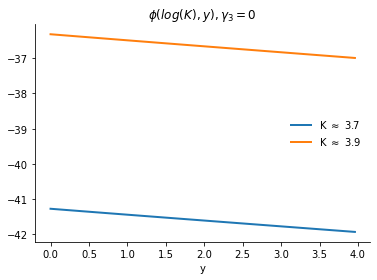

In [198]:
plt.plot(y_grid, v0[:, 26], label=r"K $\approx$ {:.1f}".format(np.exp(k_mat[0,26])))
plt.plot(y_grid, v0[:, 27], label=r"K $\approx$ {:.1f}".format(np.exp(k_mat[0,27])))
plt.legend()
plt.title(r'$\phi(log(K), y), \gamma_3 = 0$')
plt.xlabel('y')
# plt.savefig('ϕ_new.png', dpi=300)
plt.show()

In [199]:
0.015/v0, 0.015/v0.mean()

(array([[-8.80704463e-05, -9.07196065e-05, -9.35326965e-05, ...,
          2.52762278e-05,  2.50977388e-05,  2.49217756e-05],
        [-8.80685806e-05, -9.07175780e-05, -9.35304869e-05, ...,
          2.52798446e-05,  2.51013184e-05,  2.49253185e-05],
        [-8.80667165e-05, -9.07155511e-05, -9.35282792e-05, ...,
          2.52834517e-05,  2.51048882e-05,  2.49288515e-05],
        ...,
        [-8.78938690e-05, -9.05276362e-05, -9.33236180e-05, ...,
          2.55924764e-05,  2.54093737e-05,  2.52288676e-05],
        [-8.78920728e-05, -9.05256837e-05, -9.33214917e-05, ...,
          2.55955378e-05,  2.54123779e-05,  2.52318155e-05],
        [-8.78902767e-05, -9.05237312e-05, -9.33193655e-05, ...,
          2.55985996e-05,  2.54153825e-05,  2.52347637e-05]]),
 6.655550352857442e-05)

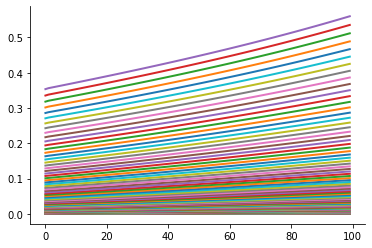

In [200]:
plt.plot(1 -  ems_new/(α*λ_bar*np.exp(k_grid)))
plt.show()

In [201]:
ems.shape

(100, 165)

Text(0.5, 0, 'y')

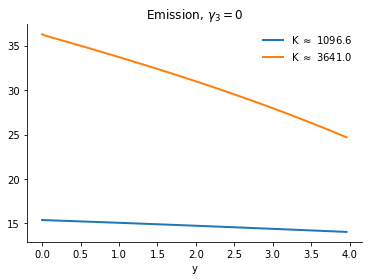

In [202]:
# plt.plot(y_grid, ems[:, -1])
index_for_k = 140
plt.plot(y_grid, ems[:, index_for_k], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[index_for_k])))
index_for_k = -1
plt.plot(y_grid, ems[:, index_for_k], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[index_for_k])))
plt.legend()
plt.title(r'Emission, $\gamma_3 = 0$')
plt.xlabel('y')
# plt.savefig('emission_new.png', dpi=300)

In [203]:
y_grid[-50], y_mat.shape

(2.0, (100, 165))

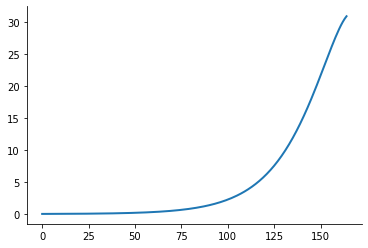

In [204]:
plt.plot(ems[-50])

Text(0.5, 1.0, 'Emission')

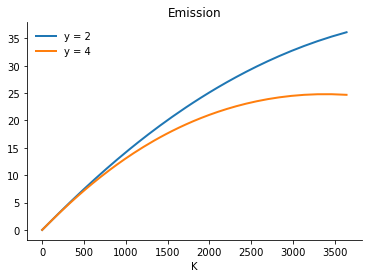

In [205]:
# plt.plot(np.exp(k_grid), ems[100], label = "y = 2")
plt.plot(np.exp(k_grid), ems[1], label = "y = 2")
plt.plot(np.exp(k_grid), ems[-1], label = "y = 4")
plt.legend()
plt.xlabel('K')
plt.title('Emission')
# plt.savefig('emission_k.png', dpi=300)

In [130]:
i, mc

(array([[0.08989952, 0.08989952, 0.08989703, ..., 0.08634968, 0.08628463,
         0.08621575],
        [0.0898991 , 0.0898991 , 0.0898966 , ..., 0.0863363 , 0.08627031,
         0.08620038],
        [0.08989868, 0.08989868, 0.08989617, ..., 0.08632541, 0.08625884,
         0.08618826],
        ...,
        [0.08986787, 0.08986787, 0.08986459, ..., 0.08539726, 0.08526801,
         0.08512718],
        [0.08986747, 0.08986747, 0.08986418, ..., 0.08538197, 0.08525147,
         0.08510925],
        [0.08986706, 0.08986706, 0.08986376, ..., 0.08536662, 0.08523488,
         0.08509126]]),
 array([[39.83988072, 39.83988072, 39.83591701, ..., 35.7706586 ,
         35.79586977, 35.82871702],
        [39.83921424, 39.83921424, 39.8352342 , ..., 35.76971352,
         35.79550761, 35.82897358],
        [39.83854839, 39.83854839, 39.83455204, ..., 35.76744407,
         35.79362073, 35.82747826],
        ...,
        [39.78970892, 39.78970892, 39.7845162 , ..., 35.86758016,
         35.93558134, 36

In [131]:
1/mc[0], 1/mc_new, ems_new, (α - i_new - np.exp(ϑ_bar)*(1 - np.exp(λ_bar)*(ems_new[0,0]/np.exp(k_mat)))**θ)

(array([0.02510048, 0.02510048, 0.02510297, 0.02510553, 0.02510816,
        0.02511085, 0.0251136 , 0.02511643, 0.02511933, 0.0251223 ,
        0.02512535, 0.02512848, 0.02513168, 0.02513497, 0.02513834,
        0.02514179, 0.02514533, 0.02514897, 0.02515269, 0.02515651,
        0.02516042, 0.02516444, 0.02516856, 0.02517278, 0.02517711,
        0.02518155, 0.0251861 , 0.02519077, 0.02519555, 0.02520046,
        0.0252055 , 0.02521066, 0.02521595, 0.02522138, 0.02522695,
        0.02523265, 0.02523851, 0.02524451, 0.02525067, 0.02525698,
        0.02526345, 0.02527009, 0.0252769 , 0.02528388, 0.02529104,
        0.02529838, 0.02530591, 0.02531363, 0.02532155, 0.02532967,
        0.025338  , 0.02534654, 0.02535529, 0.02536428, 0.02537349,
        0.02538293, 0.02539261, 0.02540255, 0.02541273, 0.02542318,
        0.02543389, 0.02544487, 0.02545613, 0.02546768, 0.02547952,
        0.02549166, 0.0255041 , 0.02551687, 0.02552995, 0.02554337,
        0.02555712, 0.02557123, 0.02558568, 0.02

In [132]:
v0_dk

array([[99.44063279, 99.44063279, 99.42660698, ..., 84.30378158,
        84.27706431, 84.26329478],
       [99.43827432, 99.43827432, 99.4241908 , ..., 84.28383077,
        84.25726963, 84.2435854 ],
       [99.43591811, 99.43591811, 99.42177694, ..., 84.26407289,
        84.23766941, 84.22407134],
       ...,
       [99.26311889, 99.26311889, 99.2447497 , ..., 83.28583372,
        83.2770947 , 83.27319157],
       [99.26084004, 99.26084004, 99.24241508, ..., 83.27758673,
        83.26918718, 83.2654726 ],
       [99.25856124, 99.25856124, 99.24008051, ..., 83.26935269,
        83.26129377, 83.2577668 ]])

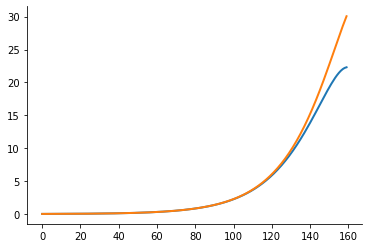

In [133]:
plt.plot(ems[-1])
plt.plot(ems[0])

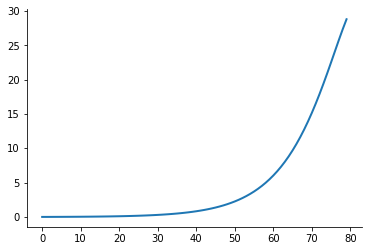

In [110]:
plt.plot(ems[0])

In [462]:
np.exp(ϑ_bar)*(1 - np.exp(λ_bar)*(ems_new/np.exp(k_mat)))

array([[3.52849119e-08, 5.82338294e-08, 9.61713094e-08, ...,
        2.42902117e-04, 5.89631289e-04, 1.47302703e-03],
       [4.60356035e-08, 7.59587233e-08, 1.25394719e-07, ...,
        2.62288049e-04, 6.21447670e-04, 1.52484168e-03],
       [1.05653075e-07, 1.74251317e-07, 2.87451808e-07, ...,
        3.69791854e-04, 7.97883964e-04, 1.81217747e-03],
       ...,
       [5.76931288e-06, 9.51204769e-06, 1.56828753e-05, ...,
        1.05826534e-02, 1.75593319e-02, 2.91090774e-02],
       [5.82893035e-06, 9.61034028e-06, 1.58449323e-05, ...,
        1.06901572e-02, 1.77357682e-02, 2.93964132e-02],
       [5.88854782e-06, 9.70863288e-06, 1.60069894e-05, ...,
        1.07976610e-02, 1.79122045e-02, 2.96837490e-02]])

In [57]:
mc_new, mc 

(array([[8.77969493e+00, 8.77969494e+00, 8.77969494e+00, ...,
         8.81877855e+00, 8.91566377e+00, 9.09591429e+00],
        [8.77969494e+00, 8.77969494e+00, 8.77969494e+00, ...,
         8.82063555e+00, 8.91993575e+00, 9.10236921e+00],
        [8.77969494e+00, 8.77969495e+00, 8.77969498e+00, ...,
         8.85516280e+00, 8.99538032e+00, 9.21219296e+00],
        ...,
        [8.77971819e+00, 8.77975815e+00, 8.77986677e+00, ...,
         1.00000000e-15, 1.00000000e-15, 1.00000000e-15],
        [8.77971867e+00, 8.77975946e+00, 8.77987035e+00, ...,
         1.00000000e-15, 1.00000000e-15, 1.00000000e-15],
        [8.77971916e+00, 8.77976079e+00, 8.77987396e+00, ...,
         1.00000000e-15, 1.00000000e-15, 1.00000000e-15]]),
 array([[9.32352511, 9.32352511, 9.32352511, ..., 9.32352511, 9.32352511,
         9.32352511],
        [9.32352511, 9.32352511, 9.32352511, ..., 9.32352511, 9.32352511,
         9.32352511],
        [9.32352511, 9.32352511, 9.32352511, ..., 9.32352511, 9.32352511,

In [375]:
θ = 2
y_bar = 2
ξa = 100_000
ϑ_bar = 0
λ_bar = 0
γ3 = γ3_list[0]
args = (δ, η, α, μk, σk, κ, θ, θ_list, σy, γ1, γ2, γ3, y_bar, ξa, ϑ_bar, λ_bar)
res = solve_new(y_grid, k_grid, args)

1e-15
Episode 0: PDE Error: nan; False Transient Error: nan; Iterations: 3600; CG Error: nan


<ipython-input-13-9d813179fe27>:61: RuntimeWarning: invalid value encountered in log
  D = np.log(mc_new) + k_mat + vd*(dΛ*np.sum(θ_mat*πa, axis=0)*ems_new + 0.5*ddΛ*σy**2*ems_new**2) \


In [7]:
# simulate
def simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, T=100, dt=1):
    periods = int(T/dt)
    Kt = np.zeros(periods)
    i = invkap
     # log capital
    Kt[0] = np.log(k0)
    k = np.log(k0)
    for t in range(periods-1):
        k +=   (αₖ + i - κ/2*i**2 - .5*σₖ**2)*dt
        Kt[t+1] = k
    return Kt

In [8]:
n_temp = 16
n_carb = 9
n_θ = len(θ_list)
θ_mat = θ_list.reshape(n_temp, n_carb)
θtemp_list = np.average(θ_mat, axis=1)
θcarb_list = np.average(θ_mat, axis=0)

In [17]:
from multiprocessing import Pool

# test for ξ_p = 2
# baseline
ξa = 0.01
ξw = 100_000
# ξp = 5
hy = 0.02
y_bar = 2
y_min = 0
y_max = 4
y_lower = 1.5

jump_interval = np.arange(y_lower,y_bar+hy, hy)
y_grid = np.arange(y_min, y_max+hy, hy)

In [25]:
def ode_y_parallel(args_list):
    with Pool(8) as p:
        res_list = p.starmap(solve_notrun, args_list)
    return res_list        

def ode_y_parallel_def(args_list):
    with Pool(8) as p:
        res_list = p.starmap(solve_smooth_100, args_list)
    return res_list        

In [23]:
def postjump_list(args_list):
    res_list = ode_y_parallel(args_list)
    ϕ_list = np.zeros((len(γ3_list), len(y_grid)))
    ems_list = np.zeros((len(γ3_list), len(y_grid)))
    for j in range(len(γ3_list)):
        ϕ_list[j ] = res_list[ j]['φ']
        ems_list[ j ] = res_list[ j]['ems']
        
    return ϕ_list, ems_list

def postjump_list_def(args_list):
    res_list = ode_y_parallel_def(args_list)
    ϕ_list = np.zeros((len(γ3_list), len(y_grid)))
    ems_list = np.zeros((len(γ3_list), len(y_grid)))
    for j in range(len(γ3_list)):
        ϕ_list[j ] = res_list[ j]['φ']
        ems_list[ j ] = res_list[ j]['ems']
        
    return ϕ_list, ems_list

In [26]:
args_list_1 = []

for γ3_i in γ3_list:
    args_func = (δ, η, θ_list, σy, γ1, γ2, γ3_i, 2, 0.01, 100_000)
    args_iter = (y_grid, args_func, 4000, 1e-7, 2)
    args_list_1.append(args_iter)

args_list_base  = []
for γ3_i in γ3_list:
    args_func = (δ, η, θ_list, σy, γ1, γ2, γ3_i, 2, 100_000, 100_000)
    args_iter = (y_grid, args_func, 4000, 1e-7, 2)
    args_list_base.append(args_iter)

In [28]:
ϕ_list1, ems_list1 = postjump_list(args_list_1)
ϕ_list2, ems_list2 = postjump_list_def(args_list_1)
# ϕ_list_base, ems_list_base = postjump_list(args_list_base)

episode: 613,	 ode error: 0.0001104623867287935,	 ft error: 9.931367550564119e-08
episode: 605,	 ode error: 0.0014831350672399601,	 ft error: 9.922756342983785e-08
episode: 525,	 ode error: 0.0007102770160836436,	 ft error: 9.924464361432683e-08
episode: 1734,	 ode error: 0.003644597052895049,	 ft error: 9.251403021437454e-08
episode: 4000,	 ode error: 8.228173616529045,	 ft error: 0.27920762780017583
episode: 4000,	 ode error: 13.23641016901187,	 ft error: 2.820597848973705e-05
episode: 4000,	 ode error: 1.3905835939894817,	 ft error: 1.3818201956006249e-06
episode: 4000,	 ode error: 0.0067592538422868165,	 ft error: 8.808267060178565e-07
episode: 4000,	 ode error: 11.760872471066216,	 ft error: 0.648726356797475
episode: 784,	 ode error: 1.4764020291921958,	 ft error: 8.296387843387265e-08
episode: 4000,	 ode error: 1.5150922486370788,	 ft error: 1.201317177645933e-05
episode: 4000,	 ode error: 14.314758756475495,	 ft error: 1.9608104278034943e-06
episode: 4000,	 ode error: 0.0486509

In [ ]:
# prep_dict = dict(
#     ϕ_list=ϕ_list, ems_list=ems_list, 
#     ϕ_list_base=ϕ_list_base, ems_list_base=ems_list_base,
#     me_list=me_list, ratio_list=ratio_list
# )

# pickle.dump(prep_dict, open("../data/prep_dict_40.p", "wb"))

In [ ]:
res_dict = pickle.load(open('../data/prep_dict_40.p', 'rb'))

ϕ_list = res_dict['φ_list']
ems_list = res_dict['ems_list']
ϕ_list_base = res_dict['φ_list_base']
ems_list_base = res_dict['ems_list_base']
me_list = res_dict['me_list']
ratio_list = res_dict['ratio_list']

# Simulation

In [29]:
class GridInterp_2d():

    def __init__(self, grids, values, method = 'Linear'):

        # unpacking
        self.grids = grids
        (self.xs, self.ys) = grids
        self.nx = len(self.xs)
        self.ny = len(self.ys)
        
        self.values = values

        assert (self.nx, self.ny) == values.shape, "ValueError: Dimensions not match"
        self.method = method

    def get_value(self, x, y):

        if self.method == 'Linear':
            
            func = RegularGridInterpolator(self.grids, self.values)
            return func([x,y])[0]

        elif self.method == 'Spline':

            func1 = CubicSpline(self.xs, self.values)
            ySpace = func1(x)
            
            func2 = CubicSpline(self.ys, ySpace)
            return func2(y)

        else:
            raise ValueError('Method Not Supported')

In [ ]:
def simulation_Matthews_R(path, method = 'Linear'):
    Time = 100
    ppy = 12
    pers = ppy * Time
    # pers = 100
    dt = Time / pers
    nDims = 5 
    its = 1
    R = data['R']
    T = data['T']
    R_mat = data['R_mat']
    phi_0 = data['phi_0']
    phi_1 = data['phi_1']
    alpha = data['alpha']
    delta = data['delta']
    F0 = data['F0']
    Fnow = data['Fnow']
    gamma_2_plus = data['gamma_2_plus']
    gamma_1 = data['gamma_1']
    gamma_2 = data['gamma_2']
    gamma_bar = data['gamma_bar']
    R_min, R_max, T_min, T_max = data['R_min'], data['R_max'], data['T_min'], data['T_max']
    gridpoints = (R, T)
    e = data['e']
    e_func_r = GridInterp_2d(gridpoints, e, method)
    def e_func(x):
        return e_func_r.get_value(log(x[0]),  x[3]) # match order
    
    i = (phi_0 * phi_1 * alpha - delta)/(phi_1 * delta + phi_0 * phi_1)
    i = i * np.ones(R_mat.shape)
    i_func_r = GridInterp_2d(gridpoints, i, method)
    def i_func(x):
        return i_func_r.get_value(log(x[0]), x[3])
    
    bar_gamma_2_plus = weight * 0 + (1 - weight) * gamma_2_plus
    
    mu_k = data['mu_k']
    sigma_k = data['sigma_k']
    sigma_r = data['sigma_r']
    sigma_T = data['sigma_T']
    R0 = data['R0']
    beta_f = data['beta_f']
    
    if endogenous and not year40:
        R_0 = 9000 - 1# from no exploration case
        F_0 = Fnow + 1
    else:
        R_0 = 9000 # from no exploration case
        F_0 = Fnow
                

    def d_Lambda(T_x):
        return gamma_1 + gamma_2 * T_x + bar_gamma_2_plus * (T_x - gamma_bar) * ((T_x - gamma_bar) > 0)
    
    def d2_Lambda(T_x):
        gamma_2 + bar_gamma_2_plus * ((T_x - gamma_bar) > 0)


    # drifts for each diffusion process
    def muR(E_x):
        return -E_x
    def muF(E_x):
        return  (E_x)
    def muT(E_x):
        return beta_f * muF(E_x)
    def mu_logK(x): 
        return (mu_k + phi_0 * np.log(1 + i_func(x) * phi_1)) - 0.5 * sigma_k ** 2
    def muD(x, E_x):
        return d_Lambda(x[3]) * muT(E_x)

    # initial points

    K_0 = 80 / alpha
    T_0 = 1
    D_0 = 0
    
    hist = np.zeros([pers, nDims])
    e_hist = np.zeros([pers])
    i_hist = np.zeros([pers])

    for tm in range(pers):
        if tm == 0:
            # initial points
            hist[0,:] = [R_0, np.log(K_0), F_0, T_0, D_0]
            e_hist[0] = e_func(hist[0,:]) * hist[0,0]
            i_hist[0] = i_func(hist[0,:])
            if endogenous:
    #                 hist[0,0] = hist[0,0] - 1
    #                 hist[0,2] = hist[0,2] + beta * 1
                e_hist[0] = e_func(hist[0,:]) * hist[0,0] + 1 / dt
            else:
                pass
        elif (tm == 40 * ppy) and year40:
            # Year 40 there could be a shock
            hist[tm,0] = hist[tm - 1,0] + muR(e_hist[tm-1]) * dt # R
            hist[tm,1] = hist[tm - 1,1] + mu_logK(hist[tm-1,:]) * dt # logK
            hist[tm,2] = hist[tm - 1,2] + muF(e_hist[tm-1]) * dt
            hist[tm,3] = hist[tm - 1,3] + muT(e_hist[tm-1]) * dt
            hist[tm,4] = hist[tm - 1,4] + muD(hist[tm-1,:], e_hist[tm-1]) * dt
            e_hist[tm] = e_func(hist[tm,:]) * hist[tm,0] + 1 / dt
            i_hist[tm] = i_func(hist[tm-1,:])
        else:
            # other periods
            hist[tm,0] = max(hist[tm - 1,0] + muR(e_hist[tm-1]) * dt, 1) # R
            hist[tm,1] = hist[tm - 1,1] + mu_logK(hist[tm-1,:]) * dt # logK
            hist[tm,2] = min(hist[tm - 1,2] + muF(e_hist[tm-1]) * dt, R_max)
            hist[tm,3] = hist[tm - 1,3] + muT(e_hist[tm-1]) * dt
            hist[tm,4] = hist[tm - 1,4] + muD(hist[tm-1,:], e_hist[tm-1]) * dt
            e_hist[tm] = e_func(hist[tm,:]) * hist[tm,0]
            i_hist[tm] = i_func(hist[tm-1,:])

    MU_E = delta * kappa / (e_hist)
    MU_C = delta * (1-kappa) / ((alpha-i_hist) * exp(hist[:,1]))
    SCC = MU_E / MU_C * 1000  
        
    return dict(e= e_hist, states= hist, SCC = SCC)